In [1]:
import numpy as np
import pandas as pd
import os
from keras.preprocessing.image import ImageDataGenerator
from sklearn.model_selection import train_test_split
from keras.utils import plot_model
from keras.models import Model
from keras.layers import Input, Dense, Flatten, concatenate
from keras.layers import Conv2D,Flatten,Dense,Dropout,BatchNormalization,MaxPooling2D
import cv2

from sklearn.preprocessing import StandardScaler
from tensorflow.keras.utils import to_categorical

import matplotlib.pyplot as plt
from tensorflow.keras.metrics import Precision, Recall, SparseCategoricalAccuracy
from tensorflow.keras.models import load_model

from sklearn.metrics import classification_report, confusion_matrix, ConfusionMatrixDisplay, roc_auc_score
import seaborn as sns

from keras.callbacks import EarlyStopping

import random


from tensorflow.keras.callbacks import TensorBoard
import time

import tensorflow as tf
import tensorflow_datasets as tfds
from tensorflow.keras import layers

from keras.regularizers import l2

In [2]:
NAME = f"dementia_only_images_{int(time.time())}"
tensorboard = TensorBoard(log_dir = "./logs/final/Final/final{}".format(NAME))

BS = 32

In [3]:
folder = "C:/Users/mohdf/OneDrive/Desktop/oasis/data/organised_mr"
excel_folder = "E:/Faheem/oasis-scripts-master/FaheemSirKaData2.csv"


# 0 -> 0; 0.5 -> 1; 1 -> 2; 2 -> 3

zero = []
point5 = []
one = []
two = []
   
for dirname, _, filenames in os.walk(folder+'/0.0'):
    for filename in filenames:
        zero.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk(folder+'/0.5'):
    for filename in filenames:
        point5.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk(folder+'/1.0'):
    for filename in filenames:
        one.append(os.path.join(dirname, filename))

for dirname, _, filenames in os.walk(folder+'/2.0'):
    for filename in filenames:
        two.append(os.path.join(dirname, filename))




len(zero),len(point5),len(one),len(two)




(70603, 16233, 20738, 4517)

In [4]:
# target_samples = 22000


def oversample(target_samples, image_list):
    original_samples = len(image_list)
    duplicate_samples = target_samples - original_samples

    duplicate_images = random.choices(image_list, k=duplicate_samples)
    
    return duplicate_images
    
two_sampled = oversample(15000,two)
zero_sampled = random.sample(zero, k=22000)

# point5_sampled = oversample(target_samples,point5)
# one_sampled = oversample(target_samples,one)
# two_sampled = oversample(target_samples,two)

# # undersample
# zero_sampled = random.sample(zero, k=target_samples)



In [5]:
print(len(zero),len(point5),len(one),len(two))
print(len(zero_sampled),len(two_sampled))
print(len(zero_sampled),len(point5),len(one),len(two)+len(two_sampled))

70603 16233 20738 4517
22000 10483
22000 16233 20738 15000


In [6]:
image_paths = []
labels = []
image_names = []

def collect(images_path,label,image_type):
    for path in images_path:
        name = path.split("/")[-1]
        name = "_".join(name.split("_")[0:3])
        name = name[4:]
        image_paths.append(path)
        labels.append(label)
        arr = [name,image_type]
        image_names.append(arr)

# since it was undersampled
collect(zero_sampled,0,"original")
# collect(point5_sampled,1,"sampled")
# collect(one_sampled,2,"sampled")
collect(two_sampled,3,"sampled")

collect(point5,1,"original")
collect(one,2,"original")
collect(two,3,"original")
    

image_paths = np.array(image_paths)
labels = np.array(labels)
image_names = np.array(image_names)

In [7]:
np.unique(image_names[:,1], return_counts=True)

(array(['original', 'sampled'], dtype='<U17'),
 array([63488, 10483], dtype=int64))

In [8]:
# train_images, test_images, train_labels, test_labels, train_names, test_names = train_test_split(
#     image_paths, labels, image_names, test_size=0.5, random_state=42
# )
# val_images, test_images, val_labels, test_labels, val_names, test_names = train_test_split(
#     train_images, train_labels, train_names, test_size=0.5, random_state=42
# )

train_images, test_images, train_labels, test_labels, train_names, test_names = train_test_split(
    image_paths, labels, image_names, test_size=0.5, random_state=42
)
val_images, test_images, val_labels, test_labels, val_names, test_names = train_test_split(
    train_images, train_labels, train_names, test_size=0.6, random_state=42
)



def image_generator(image_paths, image_names,labels, batch_size=BS):
    while True:
        for i in range(0, len(image_paths), batch_size):
            image_batch = image_paths[i:i+batch_size]
            image_name_batch = image_names[i:i+batch_size]
            label_batch = labels[i:i+batch_size]
            
            # Load and process the images in this batch
            image_array = []
            for index,path in enumerate(image_batch):
                image = cv2.imread(path)
                if image_name_batch[index][1] == "sampled":
                    image = random_augment(image)
                image = cv2.resize(image, (256, 256))
                image_array.append(image)

            image_array = np.array(image_array)
            image_array = image_array / 255.0

            yield image_array, to_categorical(label_batch, num_classes=4)

# Create the generators for training, validation, and testing
train_generator = image_generator(train_images, train_names, train_labels)
val_generator = image_generator(val_images, val_names, val_labels)
test_generator = image_generator(test_images, test_names, test_labels)

In [9]:
# Define Augmentation Functions
def flip_horizontal(image):
  """Flips the image horizontally."""
  return cv2.flip(image, 1)  # 1 for horizontal flip

def flip_vertical(image):
  """Flips the image vertically."""
  return cv2.flip(image, 0)  # 0 for vertical flip

def rotate(image, angle):
  """Rotates the image by a given angle."""
  (h, w) = image.shape[:2]
  center = (w // 2, h // 2)
  rotation_matrix = cv2.getRotationMatrix2D(center, angle, 1.0)
  return cv2.warpAffine(image, rotation_matrix, (w, h))

def scale(image, scale_factor):
  """Scales the image by a given factor."""
  return cv2.resize(image, None, fx=scale_factor, fy=scale_factor, interpolation=cv2.INTER_CUBIC)



def flip_augment(image):
  """Flips the image horizontally or vertically with random probability."""
  if random.random() > 0.5:
    return flip_horizontal(image)
  else:
    return flip_vertical(image)

def rotate_augment(image, angle_range=(-360, 360)):
  """Rotates the image by a random angle within a specified range."""
  angle = random.uniform(*angle_range)  # Random angle within the range
  return rotate(image, angle)

def scale_augment(image, scale_range=(0.5, 2)):
  """Scales the image by a random factor within a specified range."""
  scale_factor = random.uniform(*scale_range)  # Random scale factor within the range
  return scale(image, scale_factor)

def random_augment(image):
  """Applies random augmentation (flip, rotate, or scale) to the image."""
  augmentations = [flip_augment, rotate_augment, scale_augment]
  chosen_augment = random.choice(augmentations)
  return chosen_augment(image)

In [12]:
# Define the CNN model
image_input = Input(shape=(256, 256, 3))  # Updated shape based on the target_size


# CNN layers
x = Conv2D(32, (3, 3), activation='relu')(image_input)
# x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

# x = Dropout(0.25)(x)

x = Conv2D(64, (3, 3), activation='relu')(x)
# x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Dropout(0.25)(x)

x = Conv2D(128, (3, 3), activation='relu')(x)
# x = BatchNormalization()(x)
x = MaxPooling2D(pool_size=(2, 2))(x)

x = Flatten()(x)

x = Dense(64, activation='relu')(x) 
x = Dense(16, activation="relu")(x) 

output = Dense(4, activation='softmax')(x)  

In [13]:
model = Model(inputs=image_input, outputs=output)
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=[tf.keras.metrics.Precision(),'accuracy'])

In [14]:

# Define early stopping callback
early_stopping = EarlyStopping(monitor='val_loss', patience=3, restore_best_weights=True)

batch_size = BS
steps_per_epoch = len(train_images) // batch_size 
validation_steps = len(val_images) // batch_size 

history = model.fit(
    train_generator,
    steps_per_epoch= steps_per_epoch,
    validation_data= ( val_generator),
    validation_steps = validation_steps,
    epochs=15,
    callbacks=[tensorboard,early_stopping]
)



Epoch 1/15
1155/1155 [==============================] - 454s 386ms/step - loss: 1.0989 - precision: 0.6610 - accuracy: 0.5270 - val_loss: 0.8690 - val_precision: 0.7342 - val_accuracy: 0.6334
Epoch 2/15
1155/1155 [==============================] - 449s 388ms/step - loss: 0.7733 - precision: 0.7615 - accuracy: 0.6752 - val_loss: 0.6021 - val_precision: 0.8205 - val_accuracy: 0.7491
Epoch 3/15
1155/1155 [==============================] - 442s 382ms/step - loss: 0.5685 - precision: 0.8163 - accuracy: 0.7677 - val_loss: 0.4326 - val_precision: 0.8657 - val_accuracy: 0.8294
Epoch 4/15
1155/1155 [==============================] - 440s 381ms/step - loss: 0.4226 - precision: 0.8608 - accuracy: 0.8310 - val_loss: 0.3709 - val_precision: 0.8795 - val_accuracy: 0.8541
Epoch 5/15
1155/1155 [==============================] - 443s 384ms/step - loss: 0.3160 - precision: 0.8945 - accuracy: 0.8778 - val_loss: 0.2765 - val_precision: 0.9078 - val_accuracy: 0.8927
Epoch 6/15
1155/1155 [==================

In [15]:
test_steps = len(test_images) // batch_size 
loss_and_metrics = model.evaluate(test_generator, steps=test_steps)
print(f"Test Loss: {loss_and_metrics[0]}")
print(f"Test precision: {loss_and_metrics[1]}")
print(f"Test Accuracy: {loss_and_metrics[2]}")

693/693 [==============================] - 187s 270ms/step - loss: 0.0527 - precision: 0.9838 - accuracy: 0.9828
Test Loss: 0.05265147611498833
Test precision: 0.9837850332260132
Test Accuracy: 0.9827741980552673


In [16]:
loss_and_metrics

[0.05265147611498833, 0.9837850332260132, 0.9827741980552673]

In [17]:
# Predictions

test_generator = image_generator(test_images, test_names, test_labels)

test_steps = len(test_images) // batch_size
predictions = model.predict(test_generator, steps=test_steps)

# Convert predictions from one-hot to categorical labels
predicted_labels = np.argmax(predictions, axis=1)

test_generator = image_generator(test_images, test_names, test_labels)

# True labels
true_labels = []
for i in range(test_steps):
    _, labels = next(test_generator)
    true_labels.extend(np.argmax(labels, axis=1))

# Classification Report
class_names = ['0', '1', '2', '3']
report = classification_report(true_labels, predicted_labels, target_names=class_names, labels=['0', '1', '2', '3'], zero_division=1)
print("Classification Report:")
print(report)

693/693 [==============================] - 187s 270ms/step
Classification Report:
              precision    recall  f1-score   support

           0       0.98      0.97      0.98      6681
           1       0.97      0.98      0.97      4725
           2       0.98      0.99      0.99      6306
           3       1.00      0.99      0.99      4464

   micro avg       0.98      0.98      0.98     22176
   macro avg       0.98      0.98      0.98     22176
weighted avg       0.98      0.98      0.98     22176



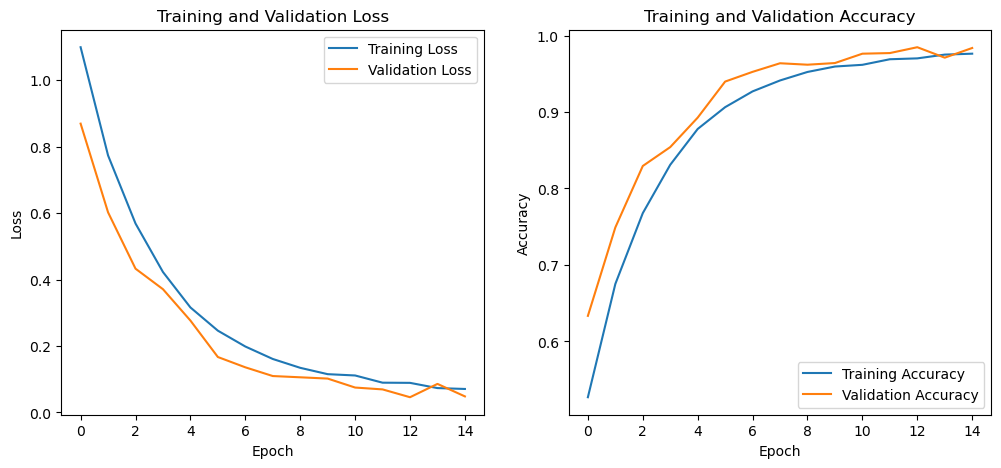

In [18]:
# Loss and Accuracy Plot
plt.figure(figsize=(12, 5))
plt.subplot(1, 2, 1)
plt.plot(history.history['loss'], label='Training Loss')
plt.plot(history.history['val_loss'], label='Validation Loss')
plt.title('Training and Validation Loss')
plt.xlabel('Epoch')
plt.ylabel('Loss')
plt.legend()

plt.subplot(1, 2, 2)
plt.plot(history.history['accuracy'], label='Training Accuracy')
plt.plot(history.history['val_accuracy'], label='Validation Accuracy')
plt.title('Training and Validation Accuracy')
plt.xlabel('Epoch')
plt.ylabel('Accuracy')
plt.legend()
plt.show()

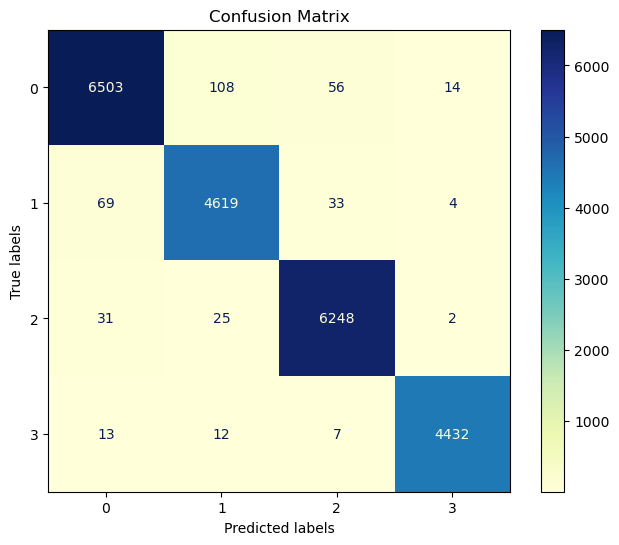

In [21]:
cm = confusion_matrix(true_labels, predicted_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=[0, 1, 2, 3])

# Create a figure and axis with the desired size
fig, ax = plt.subplots(figsize=(8, 6))  # Adjust the figure size as needed

# Plot the confusion matrix on the specified axis with the desired colormap
disp.plot(ax=ax, cmap='YlGnBu')

# Add titles and labels
plt.title('Confusion Matrix')
plt.xlabel('Predicted labels')
plt.ylabel('True labels')

# Display the plot
plt.show()

In [22]:
# Predictions

test_generator = image_generator(test_images, test_names, test_labels)

test_steps = len(test_images) // batch_size
predictions = model.predict(test_generator, steps=test_steps)

test_generator = image_generator(test_images, test_names, test_labels)

# True labels
true_labels = []
for i in range(test_steps):
    _, labels = next(test_generator)
    true_labels.extend(labels)

roc_auc = roc_auc_score(true_labels, predictions, multi_class='ovr')
print("ROC-AUC Score:", roc_auc)

693/693 [==============================] - 191s 276ms/step
ROC-AUC Score: 0.9992545263990419


In [6]:
model.save(os.path.join("CNN_images_only.h5"))

In [1]:
from tensorflow.keras.models import load_model

In [5]:
alzheimer_model = load_model(os.path.join("CNN_images_only.h5"))

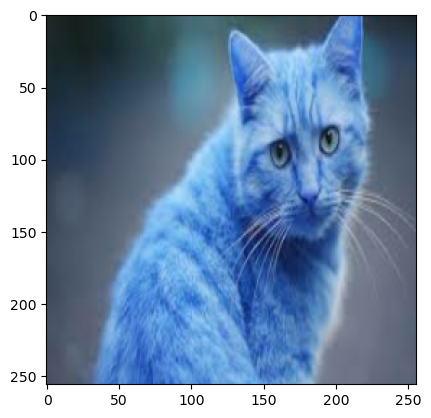

In [7]:
base = "C:/Users/mohdf/OneDrive/Desktop/oasis/data/organised_mr/"
# path = "0.5/OAS30007_MR_d2722_anat2_24.jpg"
# path =  "2.0/OAS30994_MR_d0070_anat2_138.jpg"
# path = "1.0/OAS30029_MR_d0893_anat2_76.jpg"
# path = "1.0/OAS30029_MR_d0893_anat2_157.jpg"
path = "1.0/OAS30914_MR_d0108_anat2_99.jpg"

full_path = base + path
full_path = "C:/Users/mohdf/OneDrive/Desktop/cat.jpg"
# full_path = "C:\Faheem\Faheem documents\Faheem .jpg"
# full_path = "C:\Faheem\Faheem documents\Faheem.jpg"
imgTest = cv2.imread(full_path)
resize = tf.image.resize(imgTest, (256,256))
plt.imshow(resize.numpy().astype(int))
plt.show()

In [8]:
model_prediction = alzheimer_model.predict(np.expand_dims(resize/255,0))

1/1 [==============================] - 8s 8s/step


In [9]:
for predictions in model_prediction[0]:
    print(predictions)

0.106511764
0.75769717
0.053594485
0.08219651


In [10]:
predicted_class = model_prediction.argmax(axis=1)[0]
# print(predicted_class)

if predicted_class == 0:
    print("0.0: Cognitively normal")
elif predicted_class == 1:
    print("0.5: Questionable")
elif predicted_class == 2:
    print("1.0: Mildly Demented")
else:
    print("2: Moderatly or Severely demented")

0.5: Questionable


In [2]:
def is_image_valid_mri(validator_model,path,threshold):
    img = cv2.imread(path)
    resize = tf.image.resize(img, (32,32))
    model_prediction = validator_model.predict(np.expand_dims(resize/255,0))
    if model_prediction[0][0] > threshold:
        return "invalid"
    else:
        return "valid"

In [3]:
def show_image(path):
    img = cv2.imread(path)
    resize = tf.image.resize(img, (256,256))
    plt.imshow(resize.numpy().astype(int))
    plt.show()

In [4]:
def check_for_dementia(model,path):
    img = cv2.imread(full_path)
    resize = tf.image.resize(img, (256,256))
    model_prediction = model.predict(np.expand_dims(resize/255,0))
    predicted_class = model_prediction.argmax(axis=1)[0]
   
    if predicted_class == 0:
        return "0.0: Cognitively normal"
    elif predicted_class == 1:
        return "0.5: Questionable"
    elif predicted_class == 2:
        return "1.0: Mildly Demented"
    else:
        return "2: Moderatly or Severely demented"

In [5]:
from tensorflow.keras.models import load_model

In [6]:
alzheimer_model = load_model(os.path.join("CNN_images_only.h5"))
validator_model = load_model(os.path.join("images_validator3.h5"))

In [19]:
base = "C:/Users/mohdf/OneDrive/Desktop/oasis/data/organised_mr/"
full_path = "C:/Users/mohdf/OneDrive/Desktop/car.jpg"
full_path = "C:/Users/mohdf/OneDrive/Desktop/lung04.jpg"
# path = "0.5/OAS30007_MR_d2722_anat2_24.jpg"
# path =  "2.0/OAS30994_MR_d0070_anat2_138.jpg"
# path = "1.0/OAS30029_MR_d0893_anat2_76.jpg"
# path = "1.0/OAS30029_MR_d0893_anat2_157.jpg"
# path = "1.0/OAS30914_MR_d0108_anat2_99.jpg"
full_path = base+path

In [20]:
# show_image(full_path)

In [21]:
is_valid = is_image_valid_mri(validator_model,full_path,0.1)
if is_valid == "valid":
    cdr = check_for_dementia(alzheimer_model,full_path)
    print(cdr)
else:
    print("invalid image")

1/1 [==============================] - 0s 48ms/step
2: Moderatly or Severely demented
